**Preprocessing for Features with R>0.4 on Satisfaction**

In [2]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# follows django database settings format, replace with your own settings
DATABASES = {
    'datafinal':{
        'POSTGRES_DBNAME': 'postgres',
        'POSTGRES_USERNAME': 'postgres',
        'POSTGRES_PASSWORD': 'rootroot',
        'POSTGRES_ADDRESS': 'datafinal.c50h51d04cbn.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT': 5432,
    },
}

# choose the database to use
db = DATABASES['datafinal']

# construct an engine connection string
engine_string =  ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# create sqlalchemy engine
engine = create_engine(engine_string)

# read a table from database into pandas dataframe, replace "tablename" with your table name
new_train = pd.read_sql_table('train', engine)
new_train.head()

,Gender,Customer,Age,Type_of_Travel,Class,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Gate_location,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,60.0,Business travel,Business,912.0,2.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,39.0,23.0,neutral or dissatisfied
1,Male,disloyal Customer,38.0,Business travel,Business,208.0,3.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,0.0,0.0,neutral or dissatisfied
2,Male,Loyal Customer,31.0,Business travel,Business,3147.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,0.0,satisfied
3,Male,Loyal Customer,53.0,Business travel,Business,2327.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,5.0,3.0,4.0,3.0,1.0,3.0,186.0,182.0,neutral or dissatisfied
4,Male,Loyal Customer,30.0,Personal Travel,Eco,650.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,4.0,3.0,4.0,3.0,0.0,0.0,neutral or dissatisfied


In [3]:
# read a table from database into pandas dataframe, replace "tablename" with your table name
new_test = pd.read_sql_table('test', engine)
new_test.head()

,Gender,Customer,Age,Type_of_Travel,Class,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Gate_location,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Female,Loyal Customer,52.0,Business travel,Eco,160.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,50.0,44.0,satisfied
1,Female,Loyal Customer,36.0,Business travel,Business,2863.0,1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,0.0,0.0,satisfied
2,Male,disloyal Customer,20.0,Business travel,Eco,192.0,2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44.0,Business travel,Business,3377.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,6.0,satisfied
4,Female,Loyal Customer,49.0,Business travel,Eco,1182.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0,0.0,20.0,satisfied


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [10]:
[new_test.columns[20]]

['Departure_Delay_in_Minutes']

In [13]:
# Create features for new train
nw_tr = new_train.drop(columns=["Age","Flight Distance","Inflight wifi","Departure/Arrival_time_convenient","Ease_of_Online booking","Gate_location","Food_and_drink","Seat comfort","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness","Departure_Delay_in_Minutes","Arrival_Delay_in_Minutes","Gender","Customer","satisfaction"], axis=1)
X_train = pd.get_dummies(nw_tr)

# Create target
y_train0 = new_train["satisfaction"]

X_train

,Online boarding,Inflight entertainment,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,3.0,2.0,1,0,1,0,0
1,3.0,5.0,1,0,1,0,0
2,5.0,5.0,1,0,1,0,0
3,3.0,3.0,1,0,1,0,0
4,3.0,3.0,0,1,0,1,0
...,...,...,...,...,...,...,...
103589,5.0,5.0,1,0,1,0,0
103590,5.0,1.0,1,0,1,0,0
103591,4.0,4.0,0,1,0,1,0
103592,4.0,4.0,0,1,0,1,0


In [14]:
# Create features for new test
nw_ts = new_test.drop(columns=["Age","Flight Distance","Inflight wifi","Departure/Arrival_time_convenient","Ease_of_Online booking","Gate_location","Food_and_drink","Seat comfort","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness","Departure_Delay_in_Minutes","Arrival_Delay_in_Minutes","Gender","Customer","satisfaction"], axis=1)
X_test = pd.get_dummies(nw_ts)

# Create target
y_test0 = new_test["satisfaction"]

X_test

,Online boarding,Inflight entertainment,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,4.0,5.0,1,0,0,1,0
1,4.0,4.0,1,0,1,0,0
2,2.0,2.0,1,0,0,1,0
3,4.0,1.0,1,0,1,0,0
4,1.0,2.0,1,0,0,1,0
...,...,...,...,...,...,...,...
25888,3.0,4.0,1,0,1,0,0
25889,4.0,4.0,1,0,1,0,0
25890,1.0,2.0,0,1,0,1,0
25891,4.0,4.0,1,0,1,0,0


In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
#Encode text labels into numerical values
le = LabelEncoder()
y_train = le.fit_transform(y_train0)
y_test = le.fit_transform(y_test0)

In [17]:
# Check the balance of target values
#y_encoded.value_counts()
print(y_train)
print(y_test)

[0 0 1 ... 0 1 0]
[1 1 0 ... 0 1 0]


In [18]:
pd.Series(y_train).value_counts()

0    58697
1    44897
dtype: int64

In [19]:
pd.Series(y_test).value_counts()

0    14528
1    11365
dtype: int64

**Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=100)
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Train the data
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Predict outcomes for train data set
predictions = classifier.predict(X_test)
df =pd.DataFrame({"Prediction": predictions, "Actual": y_test})
df

,Prediction,Actual
0,1,1
1,1,1
2,0,0
3,0,1
4,0,1
...,...,...
25888,1,0
25889,1,1
25890,0,0
25891,1,1


In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.8344726373923455

In [30]:
# import the confusion_matrix, which is the table of 
# true positives, false positives, true negatives, and false negatives.

from sklearn.metrics import confusion_matrix
c_matrix =confusion_matrix(y_test, predictions)
print(c_matrix)

[[12451  2077]
 [ 2209  9156]]


In [31]:
# Scikitlearn's classification_report calculates the metrics of the model
# Precision = TP/(TP + FP),  recall (sensitivity) TP/(TP + FN)
# F1 = 2(Precision * Sensitivity)/(Precision + Sensitivity)
from sklearn.metrics import classification_report
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85     14528
           1       0.82      0.81      0.81     11365

    accuracy                           0.83     25893
   macro avg       0.83      0.83      0.83     25893
weighted avg       0.83      0.83      0.83     25893



LogisticRegression


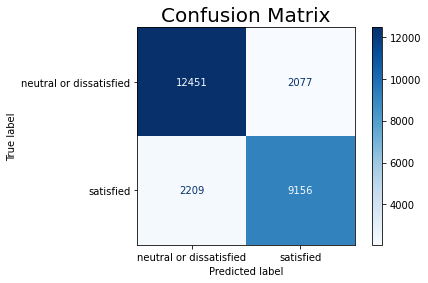

In [32]:
# plot for confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
print("LogisticRegression")
plot_confusion_matrix(classifier, X_test, y_test,cmap="Blues",values_format="d",display_labels=["neutral or dissatisfied", "satisfied"])
plt.title("Confusion Matrix", fontsize=20)
plt.grid(b=False)
plt.show()

**Random Forest Classifier**

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [38]:
RFClassifier = RandomForestClassifier(max_depth=5, n_estimators=10,max_features=1)
RFClassifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
RFClassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
rf_predictions = RFClassifier.predict(X_test)
rf_df =pd.DataFrame({"Prediction": rf_predictions, "Actual": y_test})
rf_df

,Prediction,Actual
0,1,1
1,1,1
2,0,0
3,0,1
4,0,1
...,...,...
25888,1,0
25889,1,1
25890,0,0
25891,1,1


In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, rf_predictions)

0.8619704167149422

In [42]:
# import the confusion_matrix, which is the table of 
# true positives, false positives, true negatives, and false negatives.

from sklearn.metrics import confusion_matrix
rf_c_matrix =confusion_matrix(y_test, rf_predictions)
print(rf_c_matrix)

[[12895  1633]
 [ 1941  9424]]


In [43]:
# Scikitlearn's classification_report calculates the metrics of the model
# Precision = TP/(TP + FP),  recall (sensitivity) TP/(TP + FN)
# F1 = 2(Precision * Sensitivity)/(Precision + Sensitivity)
from sklearn.metrics import classification_report
rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     14528
           1       0.85      0.83      0.84     11365

    accuracy                           0.86     25893
   macro avg       0.86      0.86      0.86     25893
weighted avg       0.86      0.86      0.86     25893



RandomForestClassifier


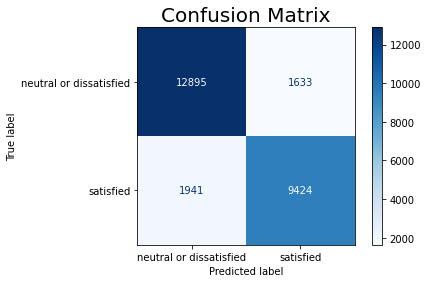

In [44]:
# plot for confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
print("RandomForestClassifier")
plot_confusion_matrix(RFClassifier, X_test, y_test,cmap="Blues",values_format="d",display_labels=["neutral or dissatisfied", "satisfied"])
plt.title("Confusion Matrix", fontsize=20)
plt.grid(b=False)
plt.show()

**Support Vector Machine**

In [45]:
SVMClassifier = make_pipeline(StandardScaler(), LinearSVC(C=0.025))
SVMClassifier

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=0.025, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [46]:
SVMClassifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=0.025, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [47]:
svm_predictions = SVMClassifier.predict(X_test)
svm_df =pd.DataFrame({"Prediction": svm_predictions, "Actual": y_test})
svm_df

,Prediction,Actual
0,1,1
1,1,1
2,0,0
3,0,1
4,0,1
...,...,...
25888,1,0
25889,1,1
25890,0,0
25891,1,1


In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_predictions)

0.8334685050013517

In [49]:
# import the confusion_matrix, which is the table of 
# true positives, false positives, true negatives, and false negatives.

from sklearn.metrics import confusion_matrix
svm_c_matrix =confusion_matrix(y_test, svm_predictions)
print(svm_c_matrix)

[[12323  2205]
 [ 2107  9258]]


In [50]:
# Scikitlearn's classification_report calculates the metrics of the model
# Precision = TP/(TP + FP),  recall (sensitivity) TP/(TP + FN)
# F1 = 2(Precision * Sensitivity)/(Precision + Sensitivity)
from sklearn.metrics import classification_report
svm_report = classification_report(y_test, svm_predictions)
print(svm_report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14528
           1       0.81      0.81      0.81     11365

    accuracy                           0.83     25893
   macro avg       0.83      0.83      0.83     25893
weighted avg       0.83      0.83      0.83     25893



SupportVectorMachine


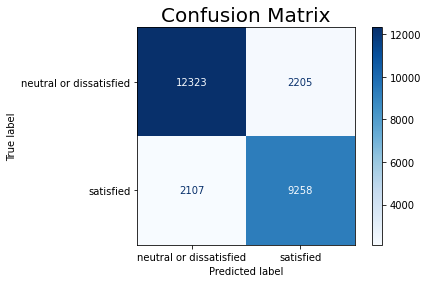

In [51]:
# plot for confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
print("SupportVectorMachine")
plot_confusion_matrix(SVMClassifier, X_test, y_test,cmap="Blues",values_format="d",display_labels=["neutral or dissatisfied", "satisfied"])
plt.title("Confusion Matrix", fontsize=20)
plt.grid(b=False)
plt.show()

In [52]:
# accuracy scores for all three models
print('LogisticRegression   : ' + str(accuracy_score(y_test, predictions)))
print('RandomForestlassifier: ' + str(accuracy_score(y_test, rf_predictions)))
print('SupportVectorMachine : ' + str(accuracy_score(y_test, svm_predictions)))


LogisticRegression   : 0.8344726373923455
RandomForestlassifier: 0.8619704167149422
SupportVectorMachine : 0.8334685050013517


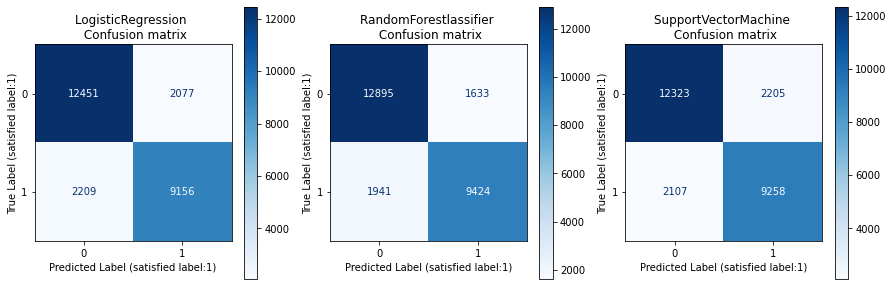

In [53]:
# prepare plots
fig, [ax_lrcm, ax_rfcm, ax_svmcm] = plt.subplots(1, 3, figsize=(15, 5))
plot_confusion_matrix(classifier, X_test, y_test,cmap="Blues",values_format="d", ax=ax_lrcm)
plot_confusion_matrix(RFClassifier, X_test, y_test,cmap="Blues",values_format="d", ax=ax_rfcm)
plot_confusion_matrix(SVMClassifier, X_test, y_test,cmap="Blues",values_format="d", ax=ax_svmcm)

ax_lrcm.set_title('LogisticRegression \n Confusion matrix')
ax_rfcm.set_title('RandomForestlassifier \n Confusion matrix')
ax_svmcm.set_title('SupportVectorMachine \n Confusion matrix')

ax_lrcm.set_xlabel("Predicted Label (satisfied label:1)")
ax_lrcm.set_ylabel("True Label (satisfied label:1)")
ax_rfcm.set_xlabel("Predicted Label (satisfied label:1)")
ax_rfcm.set_ylabel("True Label (satisfied label:1)")
ax_svmcm.set_xlabel("Predicted Label (satisfied label:1)")
ax_svmcm.set_ylabel("True Label (satisfied label:1)")
plt.show()